In [62]:
#imports
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [63]:
def clean_prices_df(path):
    df = pd.read_csv(path)
    df = df.copy()
    df.rename(columns={"Price": "Date"}, inplace=True)
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    for col in ["High", "Low", "Open", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df.dropna(inplace=True)
    return df

In [64]:
def feature_engineer_prices_df(df):
    df = df.copy()

    # --- Price Change Features ---
    df["Return_1d"] = df["Close"].pct_change()
    df["Return_7d"] = df["Close"].pct_change(7)

    # --- Moving Averages ---
    df["MA_7"] = df["Close"].rolling(7).mean()
    df["MA_14"] = df["Close"].rolling(14).mean()
    df["MA_30"] = df["Close"].rolling(30).mean()

    # --- Volatility ---
    df["Volatility_7d"] = df["Return_1d"].rolling(7).std()
    df["Volatility_14d"] = df["Return_1d"].rolling(14).std()

    # --- Volume Features ---
    df["Volume_MA_7"] = df["Volume"].rolling(7).mean()
    df["Volume_Change_1d"] = df["Volume"].pct_change()

    # --- Lagged Prices ---
    for lag in [1, 2, 3, 5, 7, 14, 21]:
        df[f"Close_Lag_{lag}"] = df["Close"].shift(lag)

    # --- RSI (Relative Strength Index) ---
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df["RSI_14"] = 100 - (100 / (1 + rs))

    # --- MACD ---
    df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = df["EMA_12"] - df["EMA_26"]
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # --- Interaction & Ratio Features ---
    df["Price_vs_MA30"] = df["Close"] / df["MA_30"]
    df["Vol_x_Return"] = df["Volume_Change_1d"] * df["Return_1d"]

    # --- Bollinger Bands ---
    df["MA_20"] = df["Close"].rolling(20).mean()
    df["Std_Dev_20"] = df["Close"].rolling(20).std()
    df["Bollinger_Upper"] = df["MA_20"] + 2 * df["Std_Dev_20"]
    df["Bollinger_Lower"] = df["MA_20"] - 2 * df["Std_Dev_20"]
    df["Price_vs_Bollinger"] = (df["Close"] - df["MA_20"]) / (2 * df["Std_Dev_20"])

    # --- Date Features ---
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["Month"] = df["Date"].dt.month
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Year"] = df["Date"].dt.year

    # --- Range Features ---
    df["Price_Range_HL"] = df["High"] - df["Low"]
    df["Price_Change_OC"] = df["Close"] - df["Open"]

    # --- Drop Early Rows ---
    df.dropna(inplace=True)
    return df

In [65]:
def prepare_ridge_data(df, target_days=7):
    df["Prediction_Base_Price"] = df["Close"].shift(target_days)
    df["Target_Return"] = df["Close"].pct_change(target_days).shift(-target_days)
    df.dropna(subset=["Target_Return", "Prediction_Base_Price"], inplace=True)

    features = df.drop(columns=["Target_Return", "Date", "Close", "Prediction_Base_Price"])
    target = df["Target_Return"]
    base_prices = df["Prediction_Base_Price"]
    dates = df["Date"]

    X_train, X_test, y_train, y_test, _, base_test, _, date_test = train_test_split(
        features, target, base_prices, dates, test_size=0.2, shuffle=False
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, base_test, date_test

In [ ]:
def train_ridge(X_train, X_test, y_train, y_test, base_prices_test):
    ridge = Ridge(alpha=10)
    ridge.fit(X_train, y_train)
    y_pred_returns = ridge.predict(X_test)

    predicted_prices = base_prices_test * (1 + y_pred_returns)
    actual_prices = base_prices_test * (1 + y_test)

    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    return actual_prices, predicted_prices, rmse

In [ ]:
def predict(ticker, path, target_days=7, label=""):
    df = clean_prices_df(path)
    df = feature_engineer_prices_df(df)
    X_train, X_test, y_train, y_test, base_prices_test, dates_test = prepare_ridge_data(df, target_days)
    actual, predicted, rmse = train_ridge(X_train, X_test, y_train, y_test, base_prices_test)

    print(f"[{ticker}] Ridge RMSE: {rmse:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(dates_test, actual, label="Actual Price")
    plt.plot(dates_test, predicted, label="Predicted Price")
    plt.title(f"{ticker} Price Prediction ({label}-Days Ahead)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

../data/raw/yf_prices/AAPL.csv
[AAPL] Ridge RMSE: 10.9095


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

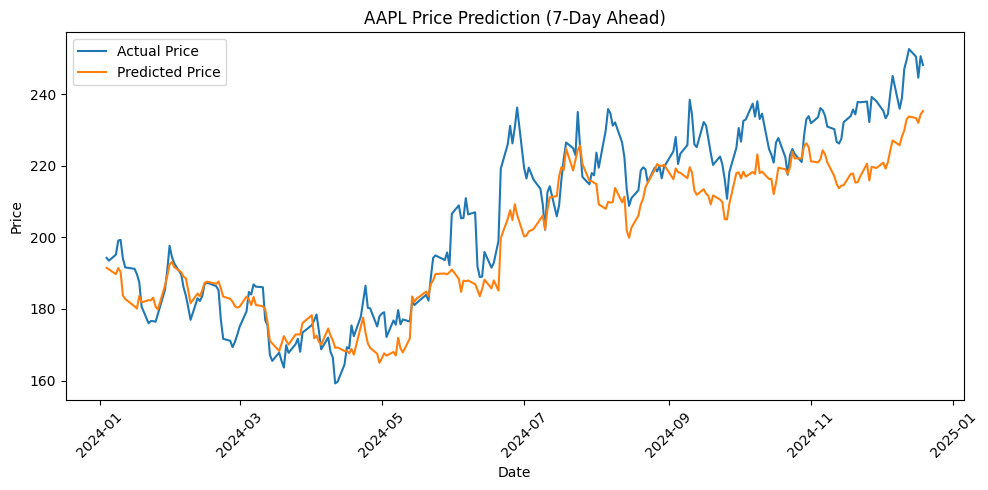

../data/raw/yf_prices/AMZN.csv
[AMZN] Ridge RMSE: 13.4057


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

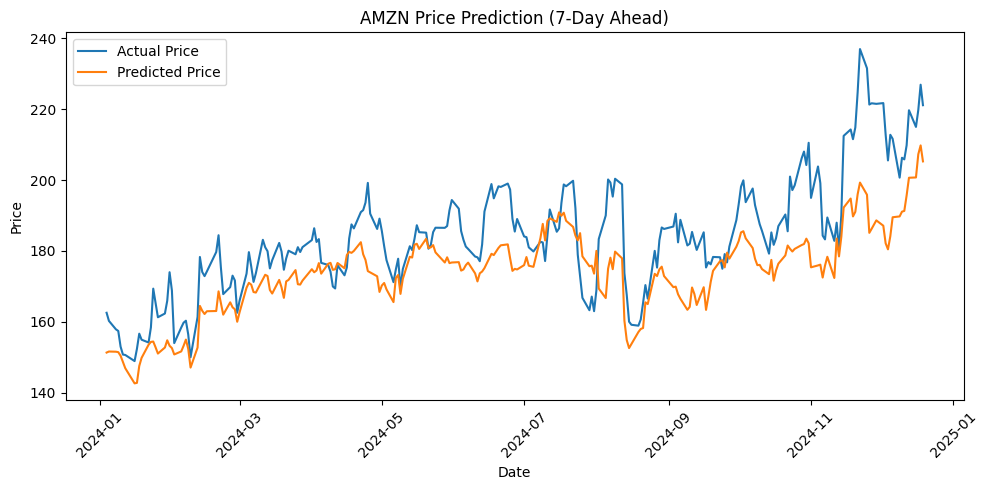

../data/raw/yf_prices/BA.csv
[BA] Ridge RMSE: 11.0020


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

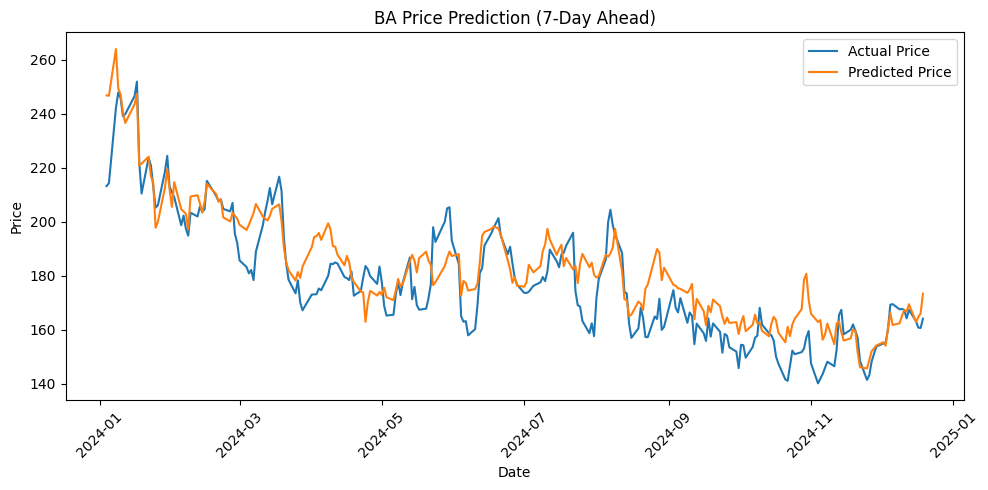

../data/raw/yf_prices/CAT.csv


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


[CAT] Ridge RMSE: 17.7475


/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/li

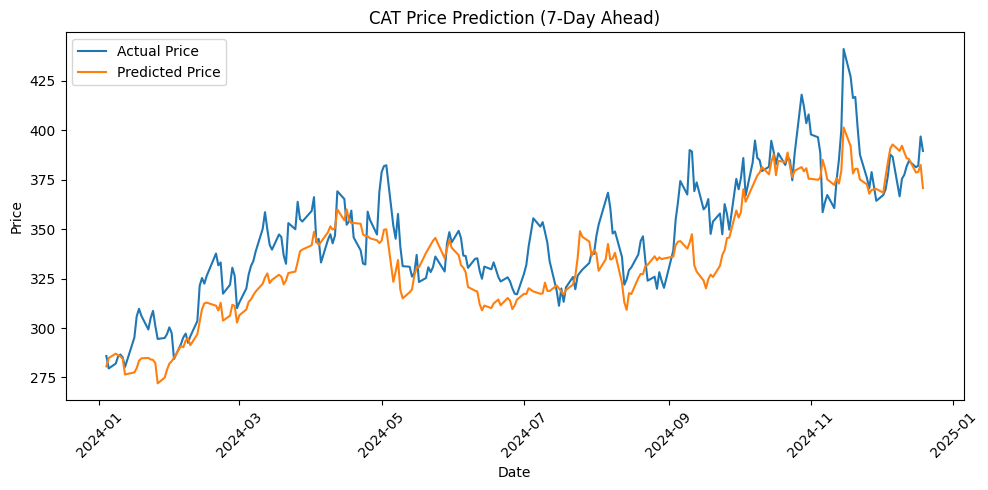

../data/raw/yf_prices/CVX.csv
[CVX] Ridge RMSE: 7.1520


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

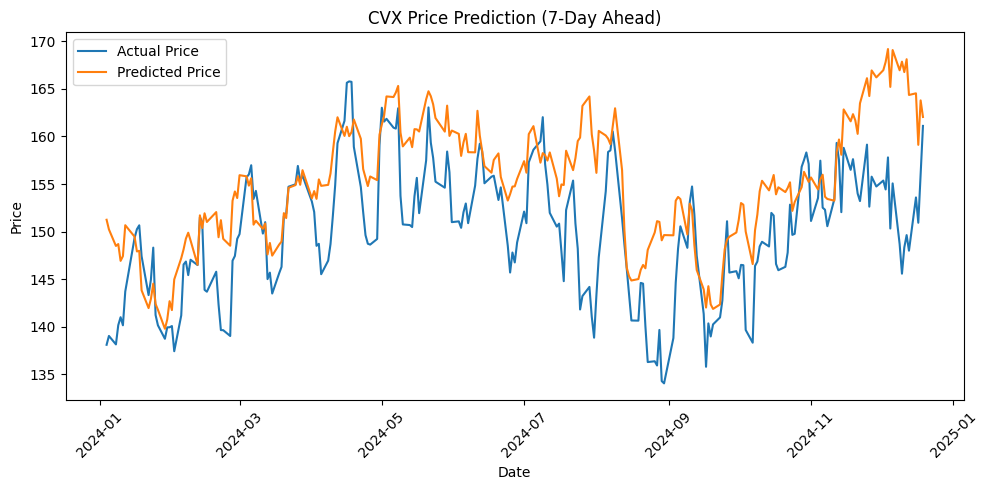

/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


../data/raw/yf_prices/GS.csv
[GS] Ridge RMSE: 20.7001


/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/li

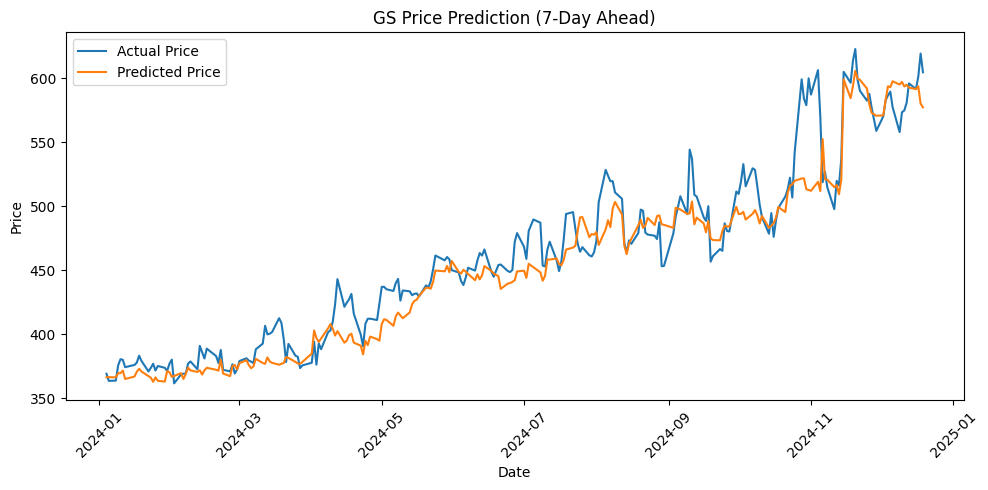

../data/raw/yf_prices/JNJ.csv


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

[JNJ] Ridge RMSE: 3.9774


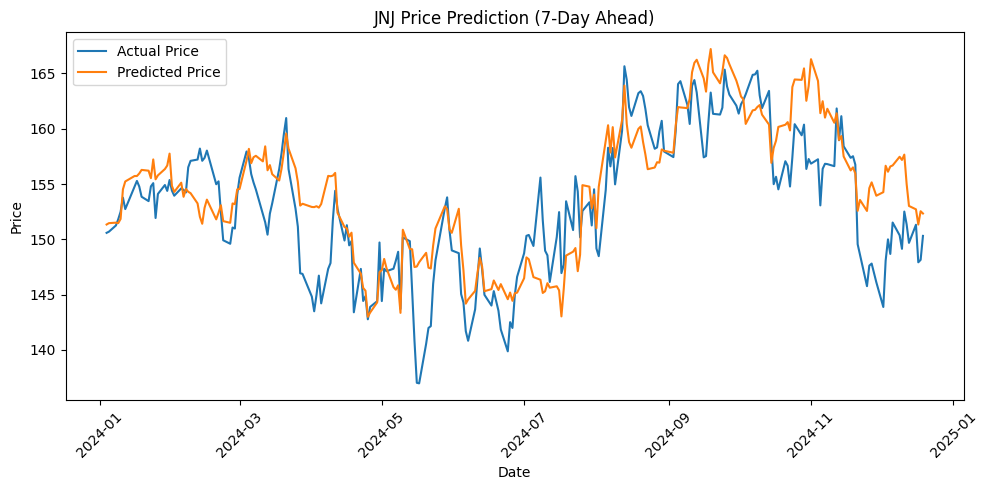

../data/raw/yf_prices/JPM.csv


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


[JPM] Ridge RMSE: 9.1715


/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/li

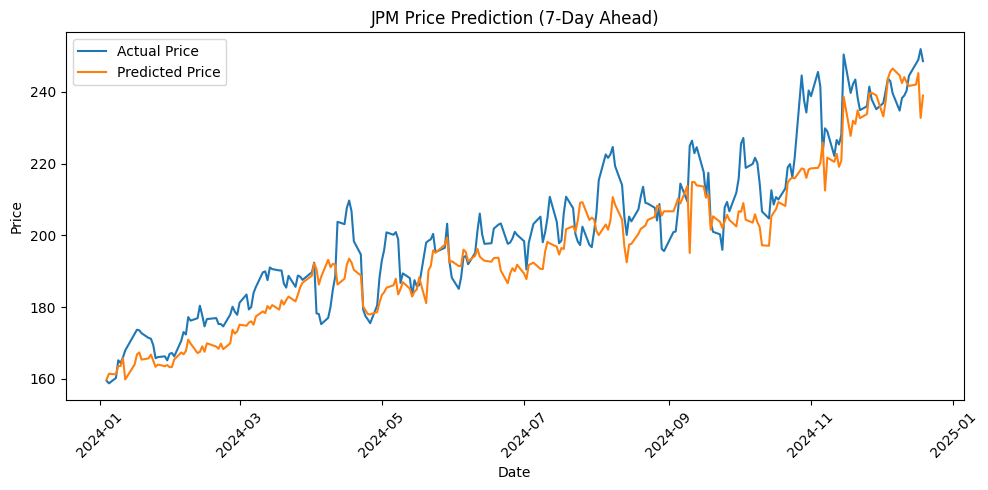

../data/raw/yf_prices/MSFT.csv
[MSFT] Ridge RMSE: 14.3041


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

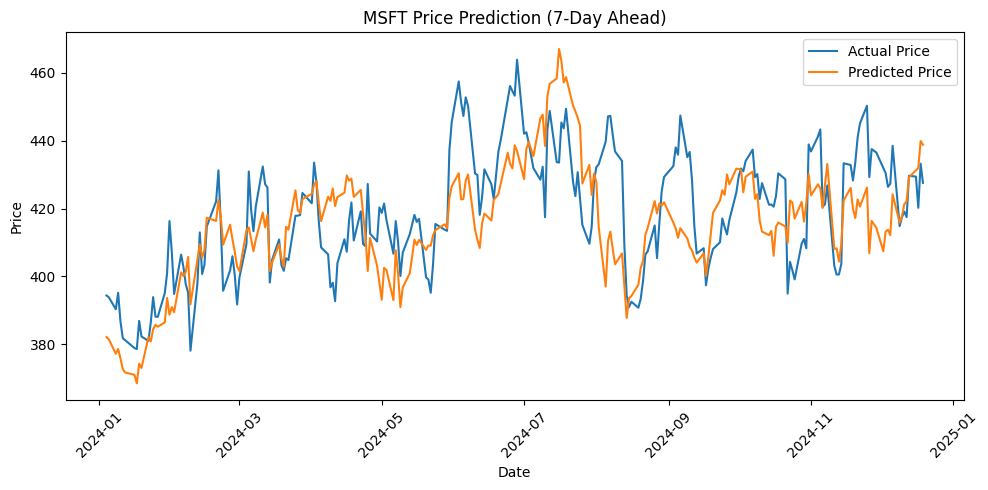

../data/raw/yf_prices/NEE.csv
[NEE] Ridge RMSE: 3.5702


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

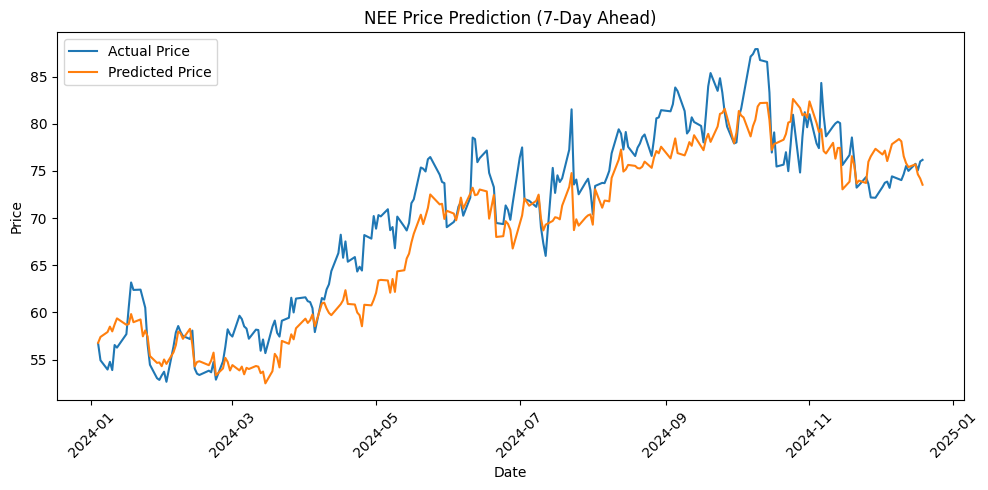

../data/raw/yf_prices/NVDA.csv


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

[NVDA] Ridge RMSE: 13.7513


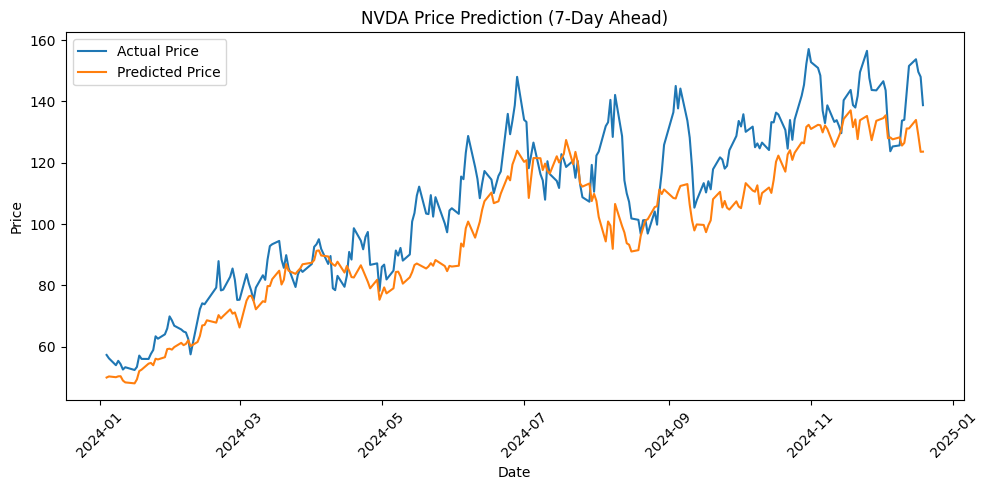

../data/raw/yf_prices/PFE.csv


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in ma

[PFE] Ridge RMSE: 1.1567


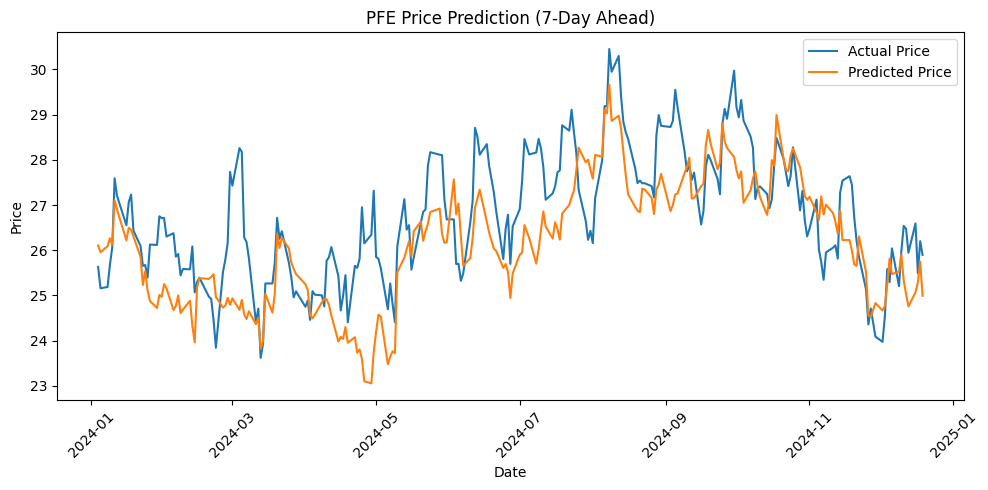

../data/raw/yf_prices/TSLA.csv


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


[TSLA] Ridge RMSE: 26.4612


/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/li

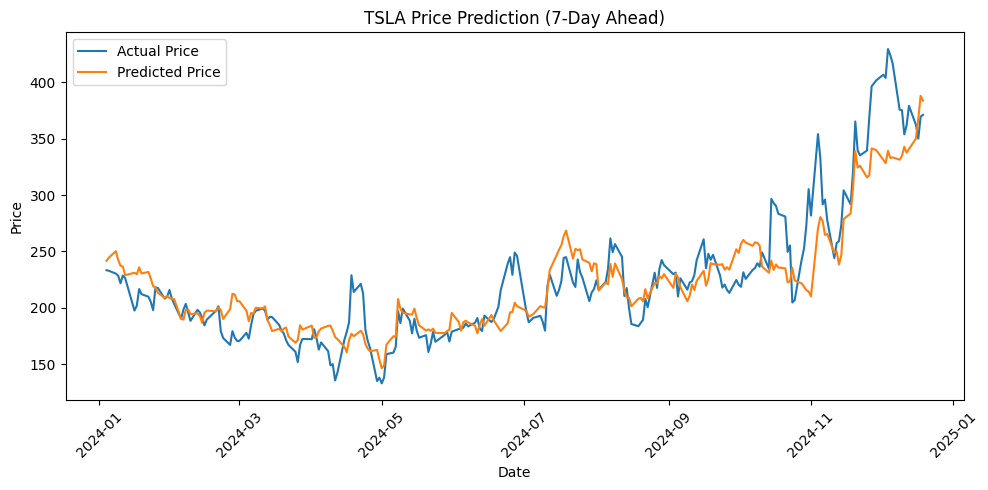

../data/raw/yf_prices/XOM.csv


/var/folders/0p/69p3h9553_9gbc2d3j6sq5h00000gn/T/ipykernel_41780/2195679571.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


[XOM] Ridge RMSE: 4.5687


/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/logan/repos/stock-price-prediction/.venv/lib/python3.12/site-packages/sklearn/li

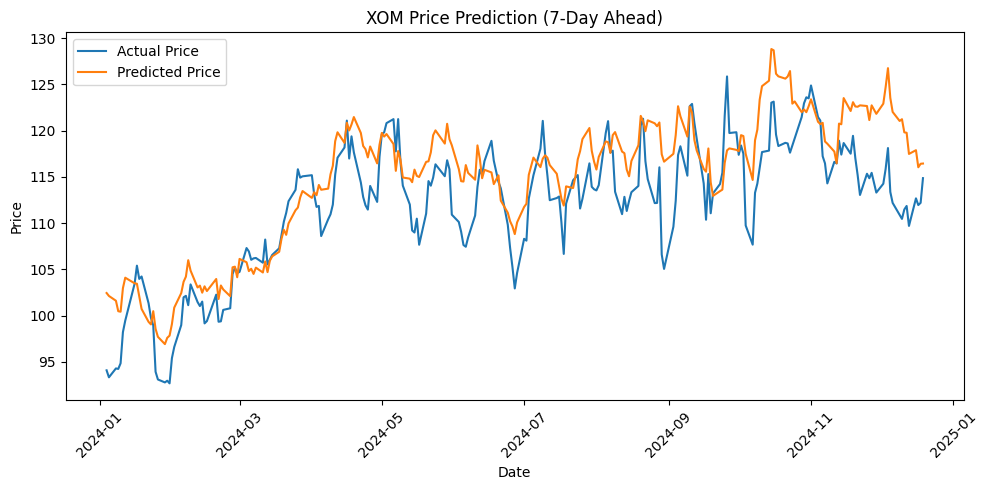

In [ ]:
tickers = ["AAPL", "AMZN", "BA", "CAT", "CVX", "GS", "JNJ", "JPM", "MSFT", "NEE", "NVDA", "PFE", "TSLA", "XOM"]
base_path = "../data/raw/yf_prices"

for ticker in tickers:
    path = os.path.join(base_path, f"{ticker}.csv")
    print(path)

    for days in [3, 7, 14]:
        predict(ticker, path, target_days=days, label=f"{days}-Days")